In [1]:
using DataFrames, FITSIO
using PyPlot
include("fitsdf.jl")

## load APOGEE, select small part of $\alpha$-Fe plane

In [2]:
cols = ["TELESCOPE", "APOGEE_ID", "APSTAR_VERSION", "RESULTS_VERSION", "ASPCAP_VERSION", "LOCATION_ID", "TEFF", "LOGG", "FE_H", "ALPHA_M"]
apogee = fitsdf("allStar-l31c.2.fits", 2, cols=cols);

In [4]:
#change -9999's to NaN's
for col in cols
    if typeof(apogee[1, Symbol(col)]) != Float32
        continue
    end
    apogee[apogee[!, Symbol(col)] .== -9999, Symbol(col)] .= NaN;
end

#make column names lower case
rename!(apogee, zip(Symbol.(cols), Symbol.(lowercase.(cols))))
;

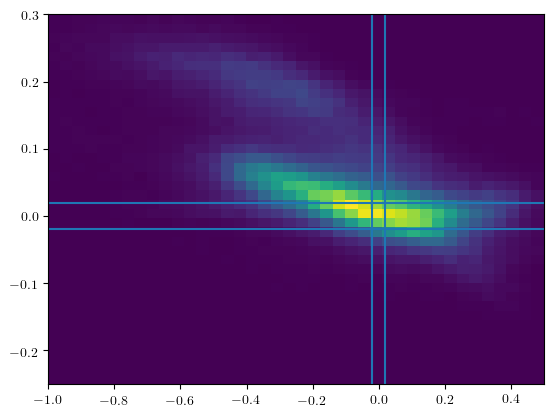

In [85]:
plt.hist2d(apogee.fe_h, apogee.alpha_m, bins=40, range=[[-1,0.5],[-0.25,0.3]])
axvline(0.02)
axvline(-0.02)
axhline(0.02)
axhline(-0.02)
;

### get just the stars in that box
#### (n.b. this excludes 1m observations.  Is this the right thing to do?)

In [86]:
mask = @. (-0.02 < apogee.fe_h < 0.02) & (-0.02 < apogee.alpha_m < 0.02) .& (apogee.telescope == "apo25m")
subset = apogee[mask, :];
println("$(sum(mask)) stars")

5455 stars


# try model with APOGEE spectra

In [88]:
#APOGEE wavelength range
λs = @. 10^(4.179 + (0:8574)*6e-6);
# http://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion
s = 10^4 ./ λs
n = @. 1 + 0.0000834254 + 0.02406147 / (130 - s^2) + 0.00015998 / (38.9 - s^2)
λs_air = λs ./ n ; 

In [ ]:
#download (if needed) and load spectra
include("getspectra.jl")
download_spectra(subset)
npix, nstars = length(λs), size(subset,1)
F = Matrix(undef, npix, nstars)
S = Matrix(undef, npix, nstars)
for (i, row) in enumerate(eachrow(subset))
    flux, err = load_spectrum(row)
    F[:, i] = flux
    S[:, i] = err
end
F[F.==0] = NaN
F .-= 1;

In [80]:
Δλ = 1
rb_air = 15288.43
rb_mask = rb_air - Δλ .< λs_air .< rb_air + Δλ
un_air = 15430.0
un_mask = un_air - Δλ .< λs_air .< un_air + Δλ
sum(un_mask)

9

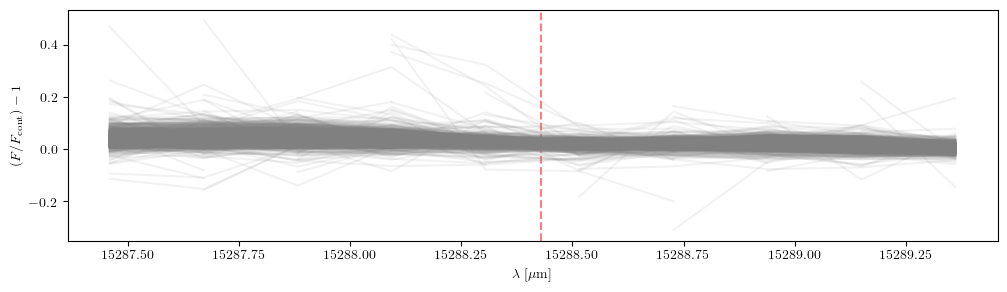

PyObject Text(0.5, 23.83700013837, '$\\lambda~\\mathrm{[\\mu m]}$')

In [84]:
figure(figsize=(12, 3))
for j in 1:size(F, 2)
    plot(λs_air[rb_mask], F[rb_mask, j], color="grey", alpha=0.1)
end
axvline(rb_air, ls="--", c="red", alpha=0.5, zorder=-1)
ylabel(L"(F/F_\mathrm{cont}) - 1")
xlabel(L"\lambda~\mathrm{[\mu m]}")

In [53]:
include("model.jl")

┌ Info: Recompiling stale cache file /Users/aw/.julia/compiled/v1.1/Optim/R5uoh.ji for Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1184


calculate_weights

In [ ]:
ba_mask = 
NN_mask = 
K = 10

to calculate distances:   0.806575 seconds (25.97 M allocations: 532.129 MiB, 12.02% gc time)
to sort:   0.000074 seconds (8 allocations: 12.203 KiB)
to calculate weights:  

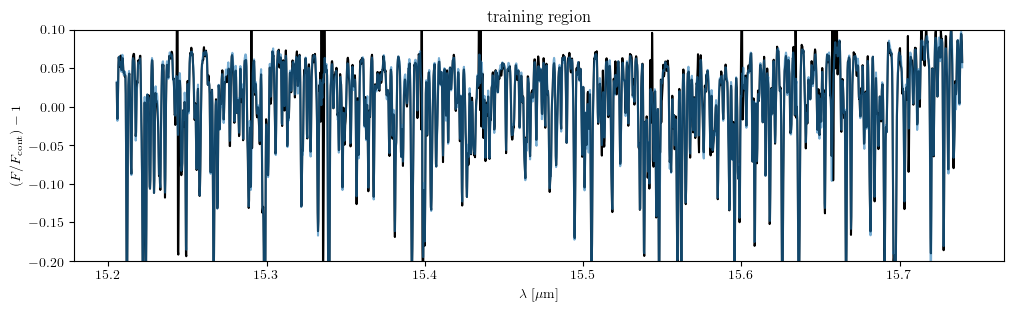

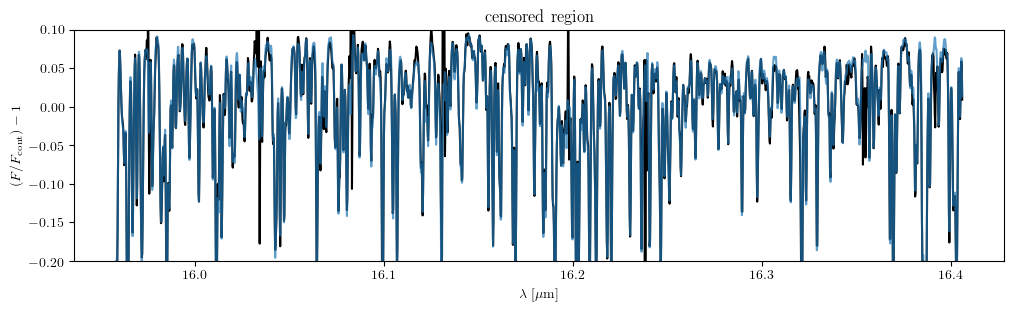

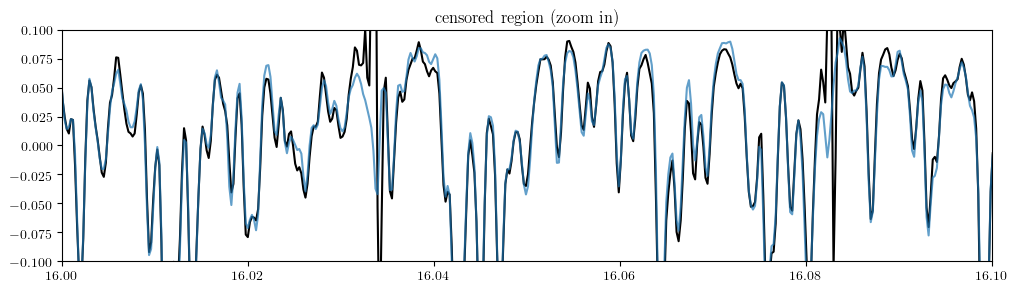

20.218026 seconds (18.30 M allocations: 3.085 GiB, 7.35% gc time)


(16, 16.1)

In [122]:
include("model.jl")
N = 10
#i = rand(1:nstars)
wlmask = 500:3000

spectral_dist(f1, s1, f2, s2) = sum(@. (f1-f2)^2/(s1^1 + s2^2))

print("to calculate distances: ")
@time dists = map(1:nstars) do j
    spectral_dist(F[wlmask, i], S[wlmask, i], F[wlmask, j], S[wlmask, j])
end

print("to sort: ")
@time perm = sortperm(dists)
neighbors = perm[2:N+1]

print("to calculate weights: ")
@time w = calculate_weights(F[wlmask, neighbors], S[wlmask, neighbors], F[wlmask, i], S[wlmask, i])

figure(figsize=(12, 3))
plot(λs[wlmask], F[wlmask, i], label="data", c="k")
plot(λs[wlmask], F[wlmask, neighbors]*w, label="best-fit model", alpha=0.6)
title("training region")
ylabel(L"(F/F_\mathrm{cont}) - 1")
xlabel(L"\lambda~\mathrm{[\mu m]}")
ylim(-0.2, 0.1)

figure(figsize=(12, 3))
plot(λs[4000:6000], F[4000:6000, i], label="data", c="k")
plot(λs[4000:6000], F[4000:6000, neighbors]*w, label="best-fit model", alpha=0.7)
title("censored region")
ylabel(L"(F/F_\mathrm{cont}) - 1")
xlabel(L"\lambda~\mathrm{[\mu m]}")
ylim(-0.2, 0.1)

figure(figsize=(12, 3))
title("censored region (zoom in)")
plot(λs[4000:6000], F[4000:6000, i], label="data", c="k")
plot(λs[4000:6000], F[4000:6000, neighbors]*w, label="best-fit model", alpha=0.7)
ylim(-0.1, 0.1)
xlim(16, 16.1)